In [1]:
%cd /home/xabush/code/snet/moses-incons-pen-xp
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import blackjax
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
from functools import partial
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

/home/xabush/code/snet/moses-incons-pen-xp


In [2]:
import os

def assign_cols(X, append_y=True):
    X_copy = X.copy()
    cols = []
    if append_y:
        for i in range(X_copy.shape[1] - 1):
            cols.append(f"f{i + 1}")

        cols.append("y")
    else:
        for i in range(X_copy.shape[1]):
            cols.append(f"f{i + 1}")
    X_copy.columns = cols

    return X_copy

def load_bmm_files(parent_dir):
    net_dir = os.path.join(parent_dir, "net")
    feat_dir = os.path.join(parent_dir, "feats")
    data_dir = os.path.join(parent_dir, "data")

    net_dfs = []
    data_dfs = []
    feat_ls = []

    with open(os.path.join(parent_dir, "rand_seeds.txt"), "r") as fp:
        seed_str = fp.readline().strip()

    seeds = [int(s) for s in seed_str.split(',')]

    for s in seeds:
        data_df = pd.read_csv(os.path.join(data_dir, f"data_bm_{s}.csv"), header=None)
        net_df = pd.read_csv(os.path.join(net_dir, f"feat_net_{s}.csv"), header=None)
        with open(os.path.join(feat_dir, f"feats_{s}.txt"), "r") as fp:
            feats_str = fp.readline().strip()

        feats = [int(f) for f in feats_str.split(',')]

        data_df = assign_cols(data_df)

        data_dfs.append(data_df)
        net_dfs.append(net_df)
        feat_ls.append(feats)


    return seeds, data_dfs, net_dfs, feat_ls

def build_network(X):
    p = X.shape[1]
    J = np.zeros((p, p))
    cols = X.columns
    intrs = []
    intrs_rev = []
    for i, g1 in enumerate(cols):
        try:
            g_intrs = list(net_intr[g1])
            for g2 in g_intrs:
                if (g2, g1) not in intrs_rev: # check if we haven't encountered the reverse interaction
                    j = cols.get_loc(g2)
                    J[i, j] = 1.0
                    J[j, i] = 1.0
                    intrs.append((g1, g2))
        except KeyError:
            continue

        # Check the reverse direction
        try:
            g_intrs_rev = list(net_intr_rev[g1])
            for g2 in g_intrs_rev:
                if (g1, g2) not in intrs:
                    j = cols.get_loc(g2)
                    J[i, j] = 1.0
                    J[j, i] = 1.0
                    intrs_rev.append((g2, g1))

        except KeyError:
            continue


    return J

def get_ess(n_chain, samples):
    k = int(samples.shape[0] / n_chain)
    chains = samples.reshape(n_chain, k, samples.shape[-1])
    ess = npyro.diagnostics.effective_sample_size(jax.device_get(chains))
    ess[np.isnan(ess)] = 1.0
    return ess

def prepare_data(seed_idx, data, nets):
    seed = seeds[seed_idx]
    X, y = data[seed_idx].iloc[:,:-1].to_numpy(), data[seed_idx].iloc[:,-1].to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, shuffle=True, stratify=y)
    net = nets[seed_idx].to_numpy()
    return seed, net, (X_train, X_test, y_train, y_test)

def recall(y_true, y_pred):
    true_positives = jnp.sum(jnp.round(jnp.clip(y_true * y_pred, 0, 1)))
    possible_positives = jnp.sum(jnp.round(jnp.clip(y_true, 0, 1)))
    return (true_positives / (possible_positives + 1e-12))

def precision(y_true, y_pred):
    true_positives = jnp.sum(jnp.round(jnp.clip(y_true * y_pred, 0, 1)))
    predicted_positives = jnp.sum(jnp.round(jnp.clip(y_pred, 0, 1)))
    return (true_positives / (predicted_positives + 1e-12))

def f1_score(y_true, y_pred):
    rec = recall(y_true, y_pred)
    prec = precision(y_true, y_pred)
    return 2*((prec*rec) / (prec + rec + 1e-12))

In [3]:
data_dir = "/home/xabush/code/snet/moses-incons-pen-xp/data"
# data_dir = "."
tamox_df = pd.read_csv(f"{data_dir}/tamoxBinaryEntrez.csv")
tamox_df.head()

,posOutcome,4111,4110,10661,131,4438,330,1109,2637,2642,...,7634,55769,7637,7644,741,54993,79364,7791,23140,26009
0,0,0,0,0,1,0,1,1,1,1,...,0,0,0,1,1,0,0,1,0,0
1,1,1,0,0,0,0,0,1,0,1,...,0,0,0,1,1,0,0,1,0,1
2,0,0,0,0,1,0,0,1,1,1,...,0,0,0,1,1,0,0,1,0,0
3,0,0,0,0,0,0,0,1,1,1,...,0,0,0,1,0,0,0,1,0,0
4,1,0,0,0,0,0,1,1,1,1,...,0,0,0,1,1,0,0,1,0,0


In [4]:
regnet_df = pd.read_table(f"{data_dir}/human.source", sep="\t", header=None, names= ["REGULATOR SYMBOL", "REGULATOR ID", "TARGET SYMBOL", "TARGET ID"])
print(f"Total interactions: {regnet_df.shape[0]}")
regnet_df.head()

Total interactions: 372774


/tmp/ipykernel_15316/3470585798.py:1: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  regnet_df = pd.read_table(f"{data_dir}/human.source", sep="\t", header=None, names= ["REGULATOR SYMBOL", "REGULATOR ID", "TARGET SYMBOL", "TARGET ID"])


,REGULATOR SYMBOL,REGULATOR ID,TARGET SYMBOL,TARGET ID
0,USF1,7391,S100A6,6277
1,USF1,7391,DUSP1,1843
2,USF1,7391,C4A,720
3,USF1,7391,ABCA1,19
4,TP53,7157,TP73,7161


In [5]:
tamox_df["posOutcome"].value_counts()

1    471
0    171
Name: posOutcome, dtype: int64

In [6]:
net_intr = pd.Series(regnet_df["REGULATOR ID"].values, index=regnet_df["TARGET ID"])
net_intr_rev = pd.Series(regnet_df["TARGET ID"].values, index=regnet_df["REGULATOR ID"])
X_df, y_df = tamox_df.iloc[:, 1:], tamox_df["posOutcome"]

In [7]:
seed = 644
rng_key = jax.random.PRNGKey(seed)
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, shuffle=True, random_state=seed,
                                                    stratify=y_df, test_size=0.3)


idx_sig = np.load(f"{data_dir}/exp_data_2/npy/idx_sig_s_{seed}.npy")
X_train, X_test = X_train.iloc[:,idx_sig], X_test.iloc[:,idx_sig]
J = build_network(X_train)

X_train, X_test = X_train.to_numpy(), X_test.to_numpy()
y_train, y_test = y_train.to_numpy(), y_test.to_numpy()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle=True, random_state=seed,
                                                    stratify=y_train, test_size=0.3)

n, p = X_train.shape
print(f"dim: {p}")

dim: 1512


In [8]:
X_train, X_val, y_train, y_val = jax.device_put(X_train), jax.device_put(X_val), jax.device_put(y_train), \
                                 jax.device_put(y_val)

X_test, y_test = jax.device_put(X_test), jax.device_put(y_test)

In [9]:
key_samples, key_init, key_warmup, key = jax.random.split(rng_key, 4)

In [10]:
class BNN(hk.Module):
    def __init__(self, output_size, feat_size, name=None):
        super().__init__(name)
        self.output_size = output_size
        self.p = feat_size
    def __call__(self, x, gamma):
        w_init = hk.initializers.TruncatedNormal(1./np.sqrt(p))
        w1 = hk.get_parameter("w1", shape=[self.p, self.p], dtype=x.dtype, init=w_init)
        w2 = hk.get_parameter("w2", shape=[self.p, 500], dtype=x.dtype, init=w_init)
        w3 = hk.get_parameter("w3", shape=[500, 200], dtype=x.dtype, init=w_init)
        w4 = hk.get_parameter("w4", shape=[200, 1], dtype=x.dtype, init=w_init)
        b1 = hk.get_parameter("b1", shape=[self.p], dtype=x.dtype, init=jnp.ones)
        b2 = hk.get_parameter("b2", shape=[500], dtype=x.dtype, init=jnp.ones)
        b3 = hk.get_parameter("b3", shape=[200], dtype=x.dtype, init=jnp.ones)
        b4 = hk.get_parameter("b4", shape=[1], dtype=x.dtype, init=jnp.ones)

        x = jnp.dot(x, jnp.diag(gamma))
        x = jnp.dot(x, w1) + b1
        x = jax.nn.silu(x)
        x = jnp.dot(x, w2) + b2
        x = jax.nn.silu(x)
        x = jnp.dot(x, w3) + b3
        x = jax.nn.silu(x)
        x = jnp.dot(x, w4) + b4
        return x

class BMM(hk.Module):
    def __init__(self, key, rate, name=None):
        super().__init__(name)
        self.key = key
        self.rate = rate

    def __call__(self, x):
        x = hk.Linear(100)(x)
        # x = hk.dropout(self.key, self.rate, x)
        x = jax.nn.relu(x)

        x = hk.Linear(100)(x)
        # x = hk.dropout(self.key, self.rate, x)
        x = jax.nn.relu(x)

        x = hk.Linear(100)(x)
        x = jax.nn.relu(x)

        x = hk.Linear(1)(x)

        return x


def model_prediction(model, params, x, gamma):
    logits = model.apply(params, x, gamma).ravel()
    return (logits > 0).astype(jnp.float32)

def net_fn(x, gamma):
    """Defines a 3-layer MLP with hidden sizes of [300, 300, 100]"""
    # model = hk.Sequential([
    #     hk.Linear(p, name="L1"), jax.nn.relu, # Feature layer
    #     hk.Linear(300, name="L2"), jax.nn.relu,
    #     # hk.Linear(300), jax.nn.relu,
    #     hk.Linear(100, name="L3"), jax.nn.relu,
    #     hk.Linear(1, name="out")
    # ])
    model = BNN(1, p, "bnn")
    return model(x, gamma)

In [24]:

def inference_loop(rng_key, model, kernel, initial_state, X_val, X_test,
                   y_val, y_test, num_samples):
    @jax.jit
    def inner_step(state, rng_key):
        state = kernel(rng_key, state)
        return state, state

    steps = 10

    @jax.jit
    def outer_step(state, key):
        """
        outer step will store 10th sample & accuracy using that sample after each one complete iteration of inner step
        """

        keys = jax.random.split(key, steps)
        state, _ = jax.lax.scan(inner_step, state, keys)
        gamma, params = state.discrete_position, state.contin_position
        val_pred = model_prediction(model, params, X_val, gamma)
        # val_acc = jnp.mean(val_pred == y_val)
        val_f1 = f1_score(y_val, val_pred)
        test_pred = model_prediction(model, params, X_test, gamma)
        # test_acc = jnp.mean(test_pred == y_test)
        test_f1 = f1_score(y_test, test_pred)

        return state, (state, val_f1, test_f1)

    n_steps = num_samples / steps
    keys = jax.random.split(rng_key, n_steps)
    final_state, (states, val_f1, test_f1) = jax.lax.scan(outer_step, initial_state, keys)
    # _, states = jax.lax.scan(inner_step, initial_state, keys)
    return final_state, states, val_f1, test_f1
    # return states

def inference_loop_multiple_chains(rng_key, kernel, initial_state, num_samples, num_chains):

    @jax.jit
    def one_step(state, step_key):
        subkeys = jax.random.split(step_key, num_chains)
        state = jax.vmap(kernel)(subkeys, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [25]:
def gamma_energy(theta, J, eta, mu):
    xg = theta.T @ J
    xgx = xg @ theta
    return eta*xgx - mu*jnp.sum(theta)

# alpha, beta = 0.5, 10.0
alpha = 1.

def generate_disc_logprob_fn(model, X, y, J, mu, eta):

    def discrete_logprob_fn(gamma, params):
        logits = model.apply(params, x=X, gamma=gamma).ravel()
        log_prior = gamma_energy(gamma, J, eta, mu)
        # log_ll = jnp.sum(tfd.Bernoulli(logits=logits).log_prob(y), axis=0)
        pos_logp = jax.nn.log_sigmoid(logits)
        neg_logp = jax.nn.log_sigmoid(-logits)
        log_ll = jnp.sum(y*pos_logp + alpha*(1 - y)*neg_logp)
        # print(f"gamma logp: {ising_logp}, log_ll: {log_ll}")

        return log_prior + log_ll

    return discrete_logprob_fn


def generate_contin_logprob_fn(model, X, y, tau, c):
    def contin_logprob_fn(gamma, params):

        flat_params, _ = jax.flatten_util.ravel_pytree(params)
        log_prior = jnp.sum(tfd.Normal(0, tau*c).log_prob(flat_params))

        logits = model.apply(params, X, gamma).ravel()
        # log_ll = jnp.sum(tfd.Bernoulli(logits=logits).log_prob(y), axis=0)
        pos_logp = jax.nn.log_sigmoid(logits)
        neg_logp = jax.nn.log_sigmoid(-logits)
        log_ll = jnp.sum(y*pos_logp + alpha*(1 - y)*neg_logp)

        return log_prior + log_ll

    return contin_logprob_fn

In [26]:
def compute_model_accuracy(param, gamma, model, X, y):
    logits = model.apply(param, X, gamma)
    pred = (logits > 0).astype(jnp.float32)
    acc = jnp.mean(pred == y)
    return acc



def posterior_prob_predict(model, gamma_samples, param_samples, X):
    """
    code taken from https://github.com/probml/pyprobml/blob/master/notebooks/book2/19/bnn_mnist_sgld_blackjax.ipynb
   net_model: neural net model for predictions
   params_sample: params of neural net sampled using MCMC
   X: data

   how to calculate posterior preds?
   .......
   Let n_samples_of_params = 5
   For given Xi:
       model_predicted_labels = [2, 2, 2, 8, 0]
       then,
       pred_prob (x1) = freq of most repeated labels / n_samles = 3/5

   returns
   .......
   posterior predictive probabilities of size len(X)
   """

    NUM_CLS = 2

    def calc_prob(i, pred_cls):
        cls_cnt = jnp.bincount(pred_cls, length=NUM_CLS)
        total = jnp.sum(cls_cnt)
        prob_c_0 = cls_cnt[0] / total
        prob_c_1 = cls_cnt[1] / total

        return i+1, jnp.array([prob_c_0, prob_c_1])


    # predictive probabilities of X for each param
    predicted_class = jax.vmap(model.apply, in_axes=(0, None, 0))(param_samples, X, gamma_samples).squeeze()

    predicted_class = predicted_class.astype(jnp.int32).T
    # posterior predictive probability using histogram
    _, posterior_pred_probs = jax.lax.scan(calc_prob, 0, predicted_class)

    return posterior_pred_probs



def get_accuracy_vs_percentage_certainity(X, y, posterior_pred_probs, model, params_samples, gamma_samples):
    thresholds = jnp.arange(0, 1.1, 0.1)
    pcts = []
    accs = []
    for thr in thresholds:
        certain_mask = posterior_pred_probs >= thr

        # accuracy
        if certain_mask.sum() == 0:
            acc_sample = 1

        else:
            acc_sample = jax.vmap(compute_model_accuracy, in_axes=(0, 0, None, None, None))(
                params_samples, gamma_samples, model, X[certain_mask], y[certain_mask]
            ).mean()

        accs.append(acc_sample)

        # percentage of certainty
        pct = jnp.mean(certain_mask.mean())
        print(pct, acc_sample)
        pcts.append(pct)

    return accs, pcts

def plot_accuracy_perc_certainity(ax, accs, pcts, thresholds, bbox=(0.8, 0.8), show_legend=True):
    ax_l = ax

    # plot perc_certainity
    ax_r = ax_l.twinx()
    pct_plot = ax_r.plot(thresholds, pcts, "-+", color="green", label="pct of certain preds")
    ax_r.set_ylabel("pct")
    ax_l.set_xlabel("certainty threshold")
    ax_r.set_ylim(0, 1.05)

    # plot accuracy
    acc_plot = ax_l.plot(thresholds, accs, "-+", label="Certainty Accuracy")
    ax_l.set_ylabel("accuracy")

    # plot accuracy on whole batch
    mn, mx = ax_r.get_xlim()
    acc_hline = ax_l.hlines(accs[0], mn, mx, color="black", linestyle="-.", label="Test accuracy")
    if show_legend:
        ax_r.legend(handles=[acc_plot[0], pct_plot[0], acc_hline], bbox_to_anchor=bbox, frameon=False)

    return ax_l, ax_r

In [28]:
from notebooks.gibbs_sampler import *
tau, c = 0.01, 100
eta, mu = 0.1, 0.1
num_samples = 5000
num_warmup = 100
num_chains = 1
disc_step_size, contin_step_size = 0.2, 1e-5

model = hk.without_apply_rng(hk.transform(net_fn))
batch = jnp.ones((n, p))
init_gamma = tfd.Bernoulli(probs=0.5*jnp.ones(p)).sample(seed=key_init)*1.
# init_params = jax.vmap(model.init, in_axes=(None, None, 0))(key_init, batch, init_gamma)
init_params = model.init(key_init, batch, init_gamma)
contin_logprob_fn = generate_contin_logprob_fn(model, X_train, y_train, tau, c)
discrete_logprob_fn = generate_disc_logprob_fn(model , X_train, y_train, J, mu, eta)
init_state = init(init_gamma, init_params, discrete_logprob_fn, contin_logprob_fn, disc_step_size, contin_step_size)
# init_state = jax.vmap(init, in_axes=(0, 0, None, None, None, None))(init_gamma, init_params, discrete_logprob_fn, contin_logprob_fn,
#                                                                     disc_step_size, contin_step_size)

In [29]:
jnp.unique(y_val, return_counts=True)

(DeviceArray([0, 1], dtype=int32), DeviceArray([36, 99], dtype=int32))

In [30]:
kernel = jax.jit(lambda key, state: one_step(key, state, discrete_logprob_fn, contin_logprob_fn, disc_step_size, contin_step_size))
final_state, states, val_f1, test_f1 = inference_loop(key_samples, model, kernel, init_state,
                                                      X_val, X_test, y_val, y_test,
                                                      num_samples)
val_f1.shape
# states = inference_loop(key_samples, model, kernel, init_state, X_val, X_test, y_val, y_test, num_samples)

2022-09-28 16:14:25.467155: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2130] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Failed to allocate request for 4.26GiB (4572288000B) on device ordinal 0
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   36.43MiB
              constant allocation:        40B
        maybe_live_out allocation:   11.74GiB
     preallocated temp allocation:   54.54MiB
  preallocated temp fragmentation:       624B (0.00%)
                 total allocation:   11.83GiB
Peak buffers:
	Buffer 1:
		Size: 4.26GiB
		XLA Label: copy
		Shape: f32[500,1512,1512]

	Buffer 2:
		Size: 4.26GiB
		Operator: op_name="jit(scan)/jit(main)/broadcast_in_dim[shape=(500, 1512, 1512) broadcast_dimensions=()]" source_file="/tmp/ipykernel_15316/2364558265.py" source_line=30
		XLA Label: broadcast
		Shape: f32[500,1512,1512]

	Buffer 3:
		Size: 1.41GiB
		XLA Label: copy
		Shape: f32[500,1512,500]

	Buf

XlaRuntimeError: RESOURCE_EXHAUSTED: Failed to allocate request for 4.26GiB (4572288000B) on device ordinal 0
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   36.43MiB
              constant allocation:        40B
        maybe_live_out allocation:   11.74GiB
     preallocated temp allocation:   54.54MiB
  preallocated temp fragmentation:       624B (0.00%)
                 total allocation:   11.83GiB
Peak buffers:
	Buffer 1:
		Size: 4.26GiB
		XLA Label: copy
		Shape: f32[500,1512,1512]
		==========================

	Buffer 2:
		Size: 4.26GiB
		Operator: op_name="jit(scan)/jit(main)/broadcast_in_dim[shape=(500, 1512, 1512) broadcast_dimensions=()]" source_file="/tmp/ipykernel_15316/2364558265.py" source_line=30
		XLA Label: broadcast
		Shape: f32[500,1512,1512]
		==========================

	Buffer 3:
		Size: 1.41GiB
		XLA Label: copy
		Shape: f32[500,1512,500]
		==========================

	Buffer 4:
		Size: 1.41GiB
		Operator: op_name="jit(scan)/jit(main)/broadcast_in_dim[shape=(500, 1512, 500) broadcast_dimensions=()]" source_file="/tmp/ipykernel_15316/2364558265.py" source_line=30
		XLA Label: broadcast
		Shape: f32[500,1512,500]
		==========================

	Buffer 5:
		Size: 190.73MiB
		XLA Label: copy
		Shape: f32[500,500,200]
		==========================

	Buffer 6:
		Size: 190.73MiB
		Operator: op_name="jit(scan)/jit(main)/broadcast_in_dim[shape=(500, 500, 200) broadcast_dimensions=()]" source_file="/tmp/ipykernel_15316/2364558265.py" source_line=30
		XLA Label: broadcast
		Shape: f32[500,500,200]
		==========================

	Buffer 7:
		Size: 17.44MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/jit(outer_step)/while/body/jit(inner_step)/jit(<lambda>)/add" source_file="/home/xabush/code/snet/moses-incons-pen-xp/notebooks/gibbs_sampler.py" source_line=63
		XLA Label: concatenate
		Shape: f32[1512,3024]
		==========================

	Buffer 8:
		Size: 12.00MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/jit(outer_step)/while/body/jit(inner_step)/jit(<lambda>)/mul" source_file="/home/xabush/miniconda3/lib/python3.9/site-packages/blackjax/mcmc/diffusion.py" source_line=20
		XLA Label: fusion
		Shape: f32[3144557]
		==========================

	Buffer 9:
		Size: 8.72MiB
		XLA Label: copy
		Shape: f32[1512,1512]
		==========================

	Buffer 10:
		Size: 8.72MiB
		Entry Parameter Subshape: f32[1512,1512]
		==========================

	Buffer 11:
		Size: 8.72MiB
		Entry Parameter Subshape: f32[1512,1512]
		==========================

	Buffer 12:
		Size: 8.72MiB
		Entry Parameter Subshape: f32[1512,1512]
		==========================

	Buffer 13:
		Size: 8.72MiB
		XLA Label: copy
		Shape: f32[1512,1512]
		==========================

	Buffer 14:
		Size: 8.72MiB
		XLA Label: copy
		Shape: f32[1512,1512]
		==========================

	Buffer 15:
		Size: 7.24MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/jit(outer_step)/while/body/jit(inner_step)/jit(<lambda>)/bnn/dot_general[dimension_numbers=(((1,), (0,)), ((), ())) precision=None preferred_element_type=None]" source_file="/tmp/ipykernel_15316/3334068148.py" source_line=18
		XLA Label: custom-call
		Shape: f32[628,3024]
		==========================



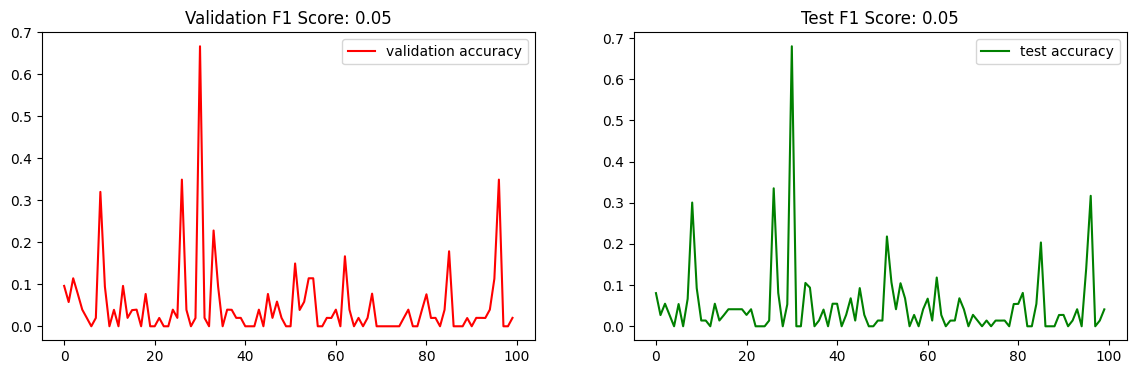

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
ax1.plot(val_f1[num_warmup:], "r", label="validation accuracy")
ax1.legend()
ax1.set_title(f"Validation F1 Score: {jnp.mean(val_f1[num_warmup:]):.2f}")

ax2.plot(test_f1[num_warmup:], "g", label="test accuracy")
ax2.set_title(f"Test F1 Score: {jnp.mean(test_f1[num_warmup:]):.2f}")
ax2.legend()

In [20]:
val_f1

DeviceArray([0.61333334, 0.590604  , 0.        , 0.84482765, 0.8118812 ,
             0.0776699 , 0.836207  , 0.        , 0.        , 0.2881356 ,
             0.05882353, 0.02      , 0.8355556 , 0.        , 0.8018019 ,
             0.146789  , 0.7922706 , 0.81938326, 0.84482765, 0.79464287,
             0.        , 0.8214286 , 0.295082  , 0.03960396, 0.84347826,
             0.77073175, 0.71657753, 0.65957445, 0.6470588 , 0.6593407 ,
             0.7963801 , 0.7604166 , 0.8340807 , 0.4324324 , 0.8073395 ,
             0.7111112 , 0.7526881 , 0.5100671 , 0.76470596, 0.57831323,
             0.78504676, 0.41221374, 0.8071749 , 0.20689656, 0.406015  ,
             0.28571427, 0.11111112, 0.25210086, 0.07619048, 0.4113475 ,
             0.31666666, 0.18181817, 0.14159292, 0.0952381 , 0.22608696,
             0.03960396, 0.07619048, 0.09615384, 0.11214954, 0.0776699 ,
             0.33333334, 0.43971634, 0.2975207 , 0.12962963, 0.25210086,
             0.40287772, 0.03960396, 0.146789  , 0.

In [22]:
states.discrete_position[3]

DeviceArray([0., 1., 0., ..., 1., 0., 0.], dtype=float32, weak_type=True)

In [36]:
# remove warmup samples
gamma_samples = jax.device_get(states.discrete_position)
param_samples = jax.device_get(states.contin_position)
gamma_samples = gamma_samples[num_warmup:]
param_samples =  jax.tree_map(lambda x: x[num_warmup:], param_samples)
gamma_mean = jnp.mean(gamma_samples, axis=0)
param_mean = jax.tree_util.tree_map(lambda x: jnp.mean(x, axis=0), param_samples)

XlaRuntimeError: RESOURCE_EXHAUSTED: Failed to allocate request for 872.09MiB (914457600B) on device ordinal 0

In [30]:
param_mean = jax.tree_util.tree_map(lambda x: x[3], states.contin_position)
gamma_mean = states.discrete_position[3]

In [39]:
param_mean

{'bnn': {'b1': DeviceArray([1.114471 , 1.0563127, 0.8770529, ..., 0.9890104, 0.9360884,
               1.0919064], dtype=float32),
  'b2': DeviceArray([0.99666834, 0.9451201 , 0.9537161 , 1.0428755 , 1.122328  ,
               0.98730564, 1.1112125 , 0.9585712 , 1.1091399 , 1.0754973 ,
               0.96470207, 0.9335122 , 0.90045136, 1.0309726 , 0.9714803 ,
               0.9633539 , 1.028244  , 1.0386386 , 0.9846919 , 0.96187496,
               0.9870108 , 0.9974179 , 1.0865328 , 0.9662719 , 0.98954815,
               0.96729004, 0.9907957 , 1.0720867 , 0.9701877 , 1.0236175 ,
               1.0128499 , 0.9886066 , 0.9794465 , 1.1025102 , 1.0055608 ,
               0.97327   , 0.9859666 , 1.0638647 , 0.96839315, 1.06556   ,
               1.0482883 , 1.005872  , 0.9329445 , 1.0747223 , 1.0705413 ,
               1.0804367 , 1.0773225 , 0.89174694, 1.0215031 , 0.9264008 ,
               1.0933161 , 1.104626  , 0.99685323, 0.9596254 , 1.0625716 ,
               0.93998814, 1.1180092 ,

In [31]:
f1_score(y_test, model_prediction(model, param_mean, X_test, gamma_mean))

DeviceArray(0.8484848, dtype=float32)

In [32]:
recall(y_test, model_prediction(model, param_mean, X_test, states.discrete_position[3]))

DeviceArray(0.9859155, dtype=float32)

In [33]:
precision(y_test, model_prediction(model, param_mean, X_test, states.discrete_position[3]))

DeviceArray(0.7446808, dtype=float32)

In [34]:
jnp.argwhere(gamma_mean > 0.9).ravel()

DeviceArray([   1,    4,    5,    6,    7,   10,   12,   14,   15,   16,
               17,   18,   20,   25,   26,   29,   30,   38,   39,   40,
               43,   44,   45,   46,   47,   50,   51,   57,   61,   62,
               63,   64,   66,   68,   70,   79,   81,   83,   84,   86,
               88,   89,   91,   92,   93,   94,   95,   97,   99,  109,
              110,  112,  113,  115,  116,  117,  119,  120,  121,  123,
              124,  126,  127,  130,  137,  138,  140,  141,  143,  147,
              148,  151,  152,  153,  160,  161,  162,  164,  166,  168,
              170,  172,  173,  175,  178,  179,  180,  181,  182,  184,
              189,  191,  193,  201,  202,  203,  205,  206,  208,  210,
              211,  214,  216,  217,  218,  220,  223,  226,  229,  230,
              232,  235,  236,  238,  239,  240,  242,  244,  247,  250,
              253,  256,  257,  260,  264,  266,  267,  269,  270,  271,
              272,  276,  277,  278,  279,  283,  2

In [36]:
model_prediction(model, param_mean, X_test, gamma_mean)

DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],            dtype=float32)

In [38]:
roc_auc_score(y_val, jax.nn.sigmoid(model.apply(param_mean, X_val, gamma_mean).ravel()))

0.6242985409652076

In [98]:
jax.nn.sigmoid(model.apply(param_mean, X_val, gamma_mean).ravel())

DeviceArray([0.29704967, 0.29704967, 0.29704967, 0.29704967, 0.29704967,
             0.29704967, 0.29704967, 0.29704967, 0.29704967, 0.29704967,
             0.29704967, 0.29704967, 0.29704967, 0.29704967, 0.29704967,
             0.29704967, 0.29704967, 0.29704967, 0.29704967, 0.29704967,
             0.29704967, 0.29704967, 0.29704967, 0.29704967, 0.29704967,
             0.29704967, 0.29704967, 0.29704967, 0.29704967, 0.29704967,
             0.29704967, 0.29704967, 0.29704967, 0.29704967, 0.29704967,
             0.29704967, 0.29704967, 0.29704967, 0.29704967, 0.29704967,
             0.29704967, 0.29704967, 0.29704967, 0.29704967, 0.29704967,
             0.29704967, 0.29704967, 0.29704967, 0.29704967, 0.29704967,
             0.29704967, 0.29704967, 0.29704967, 0.29704967, 0.29704967,
             0.29704967, 0.29704967, 0.29704967, 0.29704967, 0.29704967,
             0.29704967, 0.29704967, 0.29704967, 0.29704967, 0.29704967,
             0.29704967, 0.29704967, 0.29704967, 0.

In [81]:
y_val

DeviceArray([1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
             0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
             1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
             1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
             1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
             0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
             0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
             0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
             0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
             1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
             1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
             0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
             1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
             0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,